# Sublimation Frequencies

Author: Daniel Hogan
Created: June 20, 2024

This notebook will explore when sublimation occurred most. Was it around storms? Was it during dry, windy periods? How did sublimation rates change and how much sublimation occurred under some different general conditions.

### Imports


In [1]:
# general
import os
import glob
import datetime as dt
import json
import time
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.4.4


# Grabbing our data of interest

### First all the met data

In [9]:
# Kettle Ponds SOS Data
kp_sos_23 = xr.open_dataset('../../01_data/processed_data/sos/sos_ds_1H_storage.nc')
# kp_sos_max_23 = xr.open_dataset('../../01_data/processed_data/sos/sos_ds_1H_max_wspd_storage.nc')
kp_sos_23 = kp_sos_23.sel(time=slice('2022-12-01', '2023-03-31'))
sos_1H_h2o_flux_ds = kp_sos_23[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES]

# adjust wdir
def adjust_wdir(ds):
    new_df = ds.to_dataframe()
    new_ds = hf.adjust_wdir(new_df).to_xarray()
    ## Copy attributes from the original dataset
    new_ds.attrs = ds.attrs
    for var in new_ds:
        new_ds[var].attrs = ds[var].attrs
    return new_ds
sos_1H_h2o_flux_ds = adjust_wdir(sos_1H_h2o_flux_ds)

# Kettle Ponds SAIL Data 2022 + 2023
kp_sail_22 = xr.open_dataset('../../01_data/processed_data/sail/sail_ds_1H_met_kp_2022.nc').sel(time=slice('2021-12-01', '2022-03-31'))
kp_sail_23 = xr.open_dataset('../../01_data/processed_data/sail/sail_ds_1H_met_kp_2023.nc').sel(time=slice('2022-12-01', '2023-03-31'))

# Kettle Ponds SPLASH Data 2022
kp_splash_22 = xr.open_dataset('../../01_data/processed_data/splash/w22_splash_kp_qc_1H.nc').sel(time=slice('2021-12-01', '2022-03-31'))

# Gothic SAIL Data 2022 + 2023
gts_sail_22 = xr.open_dataset('../../01_data/processed_data/sail/sail_ds_1H_met_2022.nc').sel(time=slice('2021-12-01', '2022-03-31'))
gts_sail_23 = xr.open_dataset('../../01_data/processed_data/sail/sail_ds_1H_met_2023.nc').sel(time=slice('2022-12-01', '2023-03-31'))

# SPLASH Avery Picnic Data 2022 + 2023
ap_splash_22 = xr.open_dataset('../../01_data/processed_data/splash/w22_splash_ap_qc_1H.nc').sel(time=slice('2021-12-01', '2022-03-31'))
ap_splash_23 = xr.open_dataset('../../01_data/processed_data/splash/w23_splash_ap_qc_1H.nc').sel(time=slice('2022-12-01', '2023-03-31'))

In [10]:
x = ap_splash_22['Hl'].dropna('time')
y = kp_splash_22['Hl'].sel(time=x.time).dropna('time')
x = x.sel(time=y.time)

import scipy.stats as stats
slope, intercept, r, p, stderr = stats.linregress(x, y)

# use the regression to fill nan in kp_splash_22['Hl']
x1 = ap_splash_22['Hl']
# filled these values, but they are uncertain!!!!
kp_splash_22['Hl'] = kp_splash_22['Hl'].where(~kp_splash_22['Hl'].isnull(), x1*slope + intercept)
# filled these values, but they are uncertain!!!!

In [11]:
# pluvio buckets
w23_wbpluvio_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/pluvio2_20221001_20230930.nc').sel(time=slice('2022-12-01', '2023-03-31'))
w22_wbpluvio_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/pluvio2_20211001_20220930.nc').sel(time=slice('2021-12-01', '2022-03-31'))

In [12]:
w22_kp_sail = kp_sail_22.sel(time=slice('2021-12-01','2022-03-31'))[['wind_spd','wind_dir','mean_q','mean_t','lv','precip_rate']].to_dataframe()
w22_kp_sail['precip_rate'] = w22_wbpluvio_ds['accum_nrt'].resample(time='1H').sum()
# add kp_splash_22['Hl'] and convert from W/m^2 to mm/hr
w22_kp_sail['sublimation'] = (kp_splash_22['Hl'] * 3600 / (2834.1e3))
# fill to match the index of the kp_sos_23_sondes
# w22_kp_sail['precip'] = w22_kp_precip['binary_corrected_prcp_rate_m2']
w22_kp_sail['wind_spd'] = kp_splash_22['wspd_vec_mean'].where(~kp_splash_22['wspd_vec_mean'].isnull(),kp_sail_22['wind_spd'].values)
# interpolate missing wind speeds
w22_kp_sail['wind_spd'] = w22_kp_sail['wind_spd'].interpolate(method='linear')
# add rolling precipitation 
w22_kp_sail['rolling_24H_precip'] = w22_kp_sail['precip_rate'].rolling(window=24, center=True).sum()
# set the first 24 hours to 0 because there was no precipitation
w22_kp_sail['rolling_24H_precip'].iloc[:24] = 0
snowy_sublimation_22 = w22_kp_sail[(w22_kp_sail['rolling_24H_precip']>=1) & (w22_kp_sail['wind_spd']>=2)]
snowy_calm_sublimation_22 = w22_kp_sail[(w22_kp_sail['rolling_24H_precip']>=1) & (w22_kp_sail['wind_spd']<2)]
dry_windy_sublimation_22 = w22_kp_sail[(w22_kp_sail['rolling_24H_precip']<1) & (w22_kp_sail['wind_spd']>=2)]
dry_calm_sublimation_22 = w22_kp_sail[(w22_kp_sail['rolling_24H_precip']<1) & (w22_kp_sail['wind_spd']<2)]

(-0.5, 5.0)

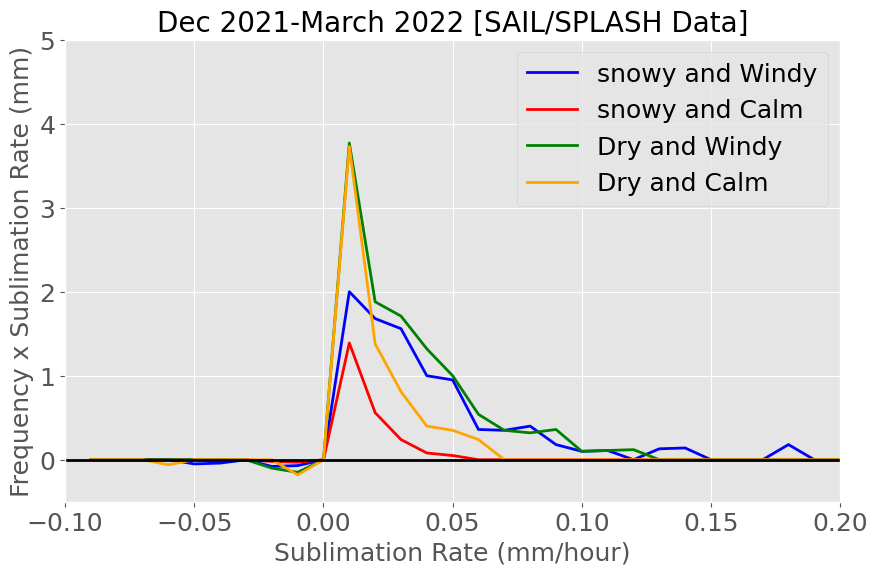

In [13]:
# total sublimation in a time interval is the sublimation rate multiplied by the frequency of that rate
# cut each sublimation rate into 0.01 g/m^2/s bins
bins = np.arange(-0.10, 0.2, 0.01)
# bins[10] = 0
def cut_bins(df, bins):
    df['binned'] = pd.cut(df['sublimation'], bins)
    return df
snowy_sublimation_freq_22 = cut_bins(snowy_sublimation_22, bins).value_counts('binned').sort_index() * bins[1:]
snowy_calm_sublimation_freq_22 = cut_bins(snowy_calm_sublimation_22, bins).value_counts('binned').sort_index() * bins[1:]
dry_windy_sublimation_freq_22 = cut_bins(dry_windy_sublimation_22, bins).value_counts('binned').sort_index() * bins[1:]
dry_calm_sublimation_freq_22 = cut_bins(dry_calm_sublimation_22, bins).value_counts('binned').sort_index() * bins[1:]
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(bins[1:], snowy_sublimation_freq_22.values, label='snowy and Windy', color='blue', lw=2)
ax.plot(bins[1:], snowy_calm_sublimation_freq_22.values, label='snowy and Calm', color='red', lw=2)
ax.plot(bins[1:], dry_windy_sublimation_freq_22.values, label='Dry and Windy', color='green', lw=2)
ax.plot(bins[1:], dry_calm_sublimation_freq_22.values, label='Dry and Calm', color='orange', lw=2)
ax.legend(fontsize=18)
ax.axhline(0, color='black', lw=2)
ax.set_xlabel('Sublimation Rate (mm/hour)', size=18)
ax.set_ylabel('Frequency x Sublimation Rate (mm)', size=18)
# increase tick label size on x and y axes
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_title('Dec 2021-March 2022 [SAIL/SPLASH Data]', size=20)
ax.set_xlim(-0.1,0.2)
ax.set_ylim(-0.5,5)

### 2023 Plot with SOS Data

In [14]:
ds = sos_1H_h2o_flux_ds
rho_w = 1000
g2kg = 1/1000
s_in_hour = 3600
sublimation_1H = (ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]] * 1/rho_w * 1000 * g2kg * s_in_hour).to_dataframe()
# get the mean at the 3 meter height
sublimation_1H = sublimation_1H[[var for var in sublimation_1H if 'w_h2o__5m' in var]].mean(axis=1).to_frame()
sublimation_1H.columns = ['sublimation_1H']
# wind speed !!!!! max wind speed !!!!!
wind_speed_1H = ds[[var for var in ds if 'spd_10m_' in var]].to_dataframe().mean(axis=1).to_frame()
wind_speed_1H.name = 'wind_speed_1H'
# if wind speed is nan, interpolate from previous and next value
wind_speed_1H = wind_speed_1H.interpolate(method='linear')
# wind direction
wind_direction_1H = sos_1H_h2o_flux_ds['dir_10m_ue']
wind_direction_1H.name = 'wind_direction_1H'
# temperature at 3m on c
temperature_1H = sos_1H_h2o_flux_ds['T_3m_c']
temperature_1H.name = 'temperature_1H'
# blowing snow flux
bsf_timestep = (ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue'])

# add preciptiation rate
precipitation_1H = xr.open_dataset('../../01_data/processed_data/splash/corrected_ldis_precipitation_rate_kps_w23.nc')['corrected_prcp_rate_m2']

# add to the sublimation rate
sublimation_1H['wind_speed_1H'] = wind_speed_1H.values
sublimation_1H['wind_direction_1H'] = wind_direction_1H.values
sublimation_1H['temperature_1H'] = temperature_1H.values
sublimation_1H['bsf'] = bsf_timestep.values
sublimation_1H['precipitation_1H'] =  w23_wbpluvio_ds['accum_nrt'].resample(time='1H').sum()
print(sublimation_1H['sublimation_1H'].sum())

19.94585516983728


In [15]:
# add rolling precipitation 
sublimation_1H['rolling_24H_precip'] = sublimation_1H['precipitation_1H'].rolling(window=48, center=True).sum()
# set the first 24 hours to 0
sublimation_1H['rolling_24H_precip'][:24] = 0
snowy_sublimation_23 = sublimation_1H[(sublimation_1H['rolling_24H_precip']>=1) & (sublimation_1H['wind_speed_1H']>=2)]
snowy_calm_sublimation_23 = sublimation_1H[(sublimation_1H['rolling_24H_precip']>=1) & (sublimation_1H['wind_speed_1H']<2)]
dry_windy_sublimation_23 = sublimation_1H[(sublimation_1H['rolling_24H_precip']<1) & (sublimation_1H['wind_speed_1H']>=2)]
dry_calm_sublimation_23 = sublimation_1H[(sublimation_1H['rolling_24H_precip']<1) & (sublimation_1H['wind_speed_1H']<2)]

In [16]:
# total sublimation in a time interval is the sublimation rate multiplied by the frequency of that rate
# cut each sublimation rate into 0.01 g/m^2/s bins
bins = np.arange(-0.10, 0.2, 0.01)
bins[10] = 0
def cut_bins(df, bins):
    df['binned'] = pd.cut(df['sublimation_1H'], bins)
    return df
snowy_sublimation_freq_23 = cut_bins(snowy_sublimation_23, bins).value_counts('binned').sort_index() * bins[1:]
snowy_calm_sublimation_freq_23 = cut_bins(snowy_calm_sublimation_23, bins).value_counts('binned').sort_index() * bins[1:]
dry_windy_sublimation_freq_23 = cut_bins(dry_windy_sublimation_23, bins).value_counts('binned').sort_index() * bins[1:]
dry_calm_sublimation_freq_23 = cut_bins(dry_calm_sublimation_23, bins).value_counts('binned').sort_index() * bins[1:]

(-0.5, 5.0)

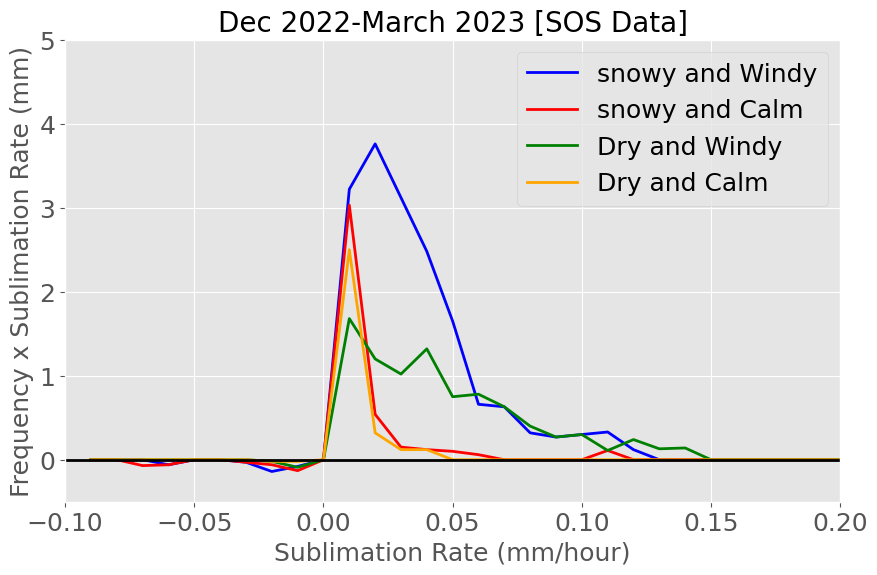

In [17]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(bins[1:], snowy_sublimation_freq_23.values, label=f'snowy and Windy', color='blue',lw=2)
ax.plot(bins[1:], snowy_calm_sublimation_freq_23.values, label='snowy and Calm', color='red',lw=2)
ax.plot(bins[1:], dry_windy_sublimation_freq_23.values, label='Dry and Windy', color='green',lw=2)
ax.plot(bins[1:], dry_calm_sublimation_freq_23.values, label='Dry and Calm', color='orange',lw=2)
ax.legend(fontsize=18)
ax.axhline(0, color='black', lw=2)
ax.set_xlabel('Sublimation Rate (mm/hour)', size=18)
ax.set_ylabel('Frequency x Sublimation Rate (mm)', size=18)
# increase tick label size on x and y axes
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_title('Dec 2022-March 2023 [SOS Data]', size=20)
ax.set_xlim(-0.1,0.2)
ax.set_ylim(-0.5,5)


In [13]:
snowy_calm_sublimation_22

,wind_spd,wind_dir,mean_q,mean_t,lv,precip_rate,size_bins,sublimation,rolling_24H_precip,binned
time,,,,,,,,,,
2021-12-06 15:00:00,0.556550,320.200012,NaN,NaN,2533000.0,0.00,0.187,0.023192,1.80,"(0.02, 0.03]"
2021-12-06 16:00:00,0.666756,NaN,NaN,NaN,NaN,0.00,0.187,0.028824,2.85,"(0.02, 0.03]"
2021-12-06 17:00:00,1.571058,NaN,NaN,NaN,NaN,0.00,0.187,0.032973,3.74,"(0.03, 0.04]"
2021-12-07 01:00:00,1.112461,319.799988,NaN,NaN,2512500.0,0.47,0.187,0.006402,5.38,"(-5.55e-17, 0.01]"
2021-12-07 02:00:00,1.638591,133.000000,NaN,NaN,2521500.0,1.33,0.187,0.002584,5.38,"(-5.55e-17, 0.01]"
...,...,...,...,...,...,...,...,...,...,...
2022-03-29 12:00:00,1.393753,277.899994,NaN,NaN,2503000.0,0.06,0.187,NaN,3.53,NaN
2022-03-29 13:00:00,0.937925,88.529999,NaN,NaN,2505500.0,0.07,0.187,NaN,3.53,NaN
2022-03-29 14:00:00,0.792491,0.525100,NaN,NaN,2526500.0,0.41,0.187,NaN,3.53,NaN


(-0.5, 5.0)

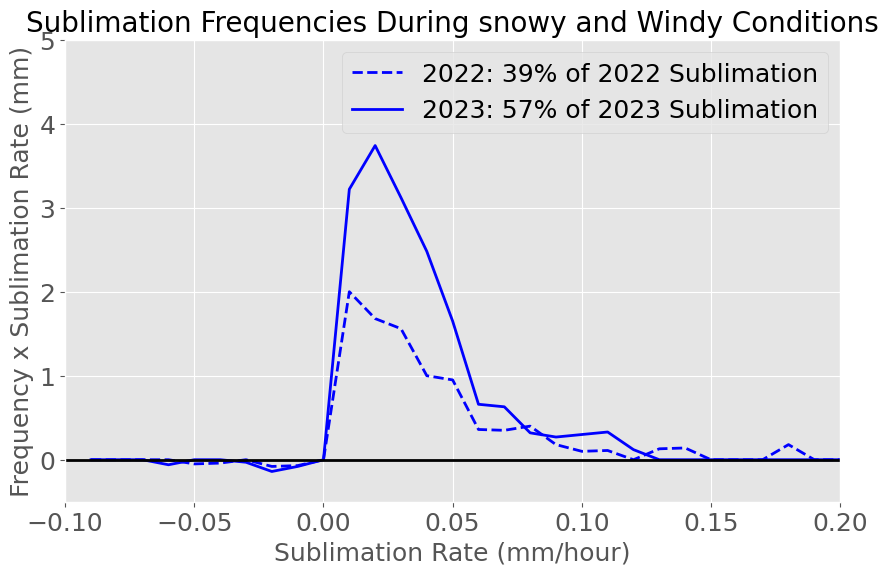

In [14]:
# plot a comparison of snowy and windy conditions for the two years
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(bins[1:], snowy_sublimation_freq_22.values, label=f"2022: {(100*snowy_sublimation_22['sublimation'].sum()/w22_kp_sail['sublimation'].sum()):.0f}% of 2022 Sublimation", color='blue',lw=2, ls='--')
ax.plot(bins[1:], snowy_sublimation_freq_23.values, label=f"2023: {(100*snowy_sublimation_23['sublimation_1H'].sum()/sublimation_1H['sublimation_1H'].sum()):.0f}% of 2023 Sublimation", color='blue',lw=2)
ax.legend(fontsize=18)
ax.axhline(0, color='black', lw=2)
ax.set_xlabel('Sublimation Rate (mm/hour)', size=18)
ax.set_ylabel('Frequency x Sublimation Rate (mm)', size=18)
# increase tick label size on x and y axes
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_title('Sublimation Frequencies During snowy and Windy Conditions', size=20)
ax.set_xlim(-0.1,0.2)
ax.set_ylim(-0.5,5)

In [15]:
# make two stacked bar plots with the number of hours in each category for each year
fig = go.Figure()

fig.add_trace(go.Bar(x=[2022], y=[snowy_sublimation_22.shape[0]], offsetgroup=0, name='snowy and Windy', marker_color='blue'))
fig.add_trace(go.Bar(x=[2022], y=[snowy_calm_sublimation_22.shape[0]], offsetgroup=1, name='snowy and Calm', marker_color='red', base=snowy_sublimation_22.shape[0]))
fig.add_trace(go.Bar(x=[2022], y=[dry_windy_sublimation_22.shape[0]], offsetgroup=2, name='Dry and Windy', marker_color='green', base=snowy_sublimation_22.shape[0]+snowy_calm_sublimation_22.shape[0]))
fig.add_trace(go.Bar(x=[2022], y=[dry_calm_sublimation_22.shape[0]], offsetgroup=3, name='Dry and Calm', marker_color='orange', base=snowy_sublimation_22.shape[0]+snowy_calm_sublimation_22.shape[0]+dry_windy_sublimation_22.shape[0]))
# fill the remainder up to 2904 as a nan value
fig.add_trace(go.Bar(x=[2022], y=[2904-snowy_sublimation_22.shape[0]-snowy_calm_sublimation_22.shape[0]-dry_windy_sublimation_22.shape[0]-dry_calm_sublimation_22.shape[0]],
                        offsetgroup=4,
                        name='No Data',
                        marker_color='gray',
                        base=snowy_sublimation_22.shape[0]+snowy_calm_sublimation_22.shape[0]+dry_windy_sublimation_22.shape[0]+dry_calm_sublimation_22.shape[0]))

fig.add_trace(go.Bar(x=[2023], y=[snowy_sublimation_23.shape[0]], offsetgroup=0, showlegend=False, marker_color='blue'))
fig.add_trace(go.Bar(x=[2023], y=[snowy_calm_sublimation_23.shape[0]], offsetgroup=1, showlegend=False, marker_color='red', base=snowy_sublimation_23.shape[0]))
fig.add_trace(go.Bar(x=[2023], y=[dry_windy_sublimation_23.shape[0]], offsetgroup=2, showlegend=False, marker_color='green', base=snowy_sublimation_23.shape[0]+snowy_calm_sublimation_23.shape[0]))
fig.add_trace(go.Bar(x=[2023], y=[dry_calm_sublimation_23.shape[0]], offsetgroup=3, showlegend=False, marker_color='orange', base=snowy_sublimation_23.shape[0]+snowy_calm_sublimation_23.shape[0]+dry_windy_sublimation_23.shape[0]))
# fill the remainder up to 2904 as a nan value
fig.add_trace(go.Bar(x=[2023], y=[2904-snowy_sublimation_23.shape[0]-snowy_calm_sublimation_23.shape[0]-dry_windy_sublimation_23.shape[0]-dry_calm_sublimation_23.shape[0]], 
                     offsetgroup=4, 
                     showlegend=False, 
                     marker_color='gray',
                    base=snowy_sublimation_23.shape[0]+snowy_calm_sublimation_23.shape[0]+dry_windy_sublimation_23.shape[0]+dry_calm_sublimation_23.shape[0]))

fig.update_layout(barmode='stack', xaxis_title='Year', 
                  yaxis_title='Frequency (hours)', 
                  showlegend=True,
                  height=600, width=800,)
# make the x axis ticks just the years
fig.update_xaxes(tickvals=[2022,2023])


In [16]:
import plotly.graph_objects as go

fig = go.Figure()

# Add primary y-axis bars
fig.add_trace(go.Bar(x=[2022], y=[snowy_sublimation_22.shape[0]], offsetgroup=0, name='snowy and Windy', marker_color='blue'))
fig.add_trace(go.Bar(x=[2022], y=[snowy_calm_sublimation_22.shape[0]], offsetgroup=1, name='snowy and Calm', marker_color='red'))
fig.add_trace(go.Bar(x=[2022], y=[dry_windy_sublimation_22.shape[0]], offsetgroup=2, name='Dry and Windy', marker_color='green'))
fig.add_trace(go.Bar(x=[2022], y=[dry_calm_sublimation_22.shape[0]], offsetgroup=3, name='Dry and Calm', marker_color='orange'))
# fig.add_trace(go.Bar(x=[2022], y=[2904 - snowy_sublimation_22.shape[0] - snowy_calm_sublimation_22.shape[0] - dry_windy_sublimation_22.shape[0] - dry_calm_sublimation_22.shape[0]],
#                      offsetgroup=4, name='No Data', marker_color='gray'))

fig.add_trace(go.Bar(x=[2023], y=[snowy_sublimation_23.shape[0]], offsetgroup=0, showlegend=False, marker_color='blue'))
fig.add_trace(go.Bar(x=[2023], y=[snowy_calm_sublimation_23.shape[0]], offsetgroup=1, showlegend=False, marker_color='red'))
fig.add_trace(go.Bar(x=[2023], y=[dry_windy_sublimation_23.shape[0]], offsetgroup=2, showlegend=False, marker_color='green'))
fig.add_trace(go.Bar(x=[2023], y=[dry_calm_sublimation_23.shape[0]], offsetgroup=3, showlegend=False, marker_color='orange'))
# fig.add_trace(go.Bar(x=[2023], y=[2904 - snowy_sublimation_23.shape[0] - snowy_calm_sublimation_23.shape[0] - dry_windy_sublimation_23.shape[0] - dry_calm_sublimation_23.shape[0]], 
#                      offsetgroup=4, showlegend=False, marker_color='gray'))

# Add secondary y-axis bars
fig.add_trace(go.Bar(x=[2022], y=[w22_kp_sail['sublimation'].sum()], offsetgroup=4, name='Sublimation', marker_color='purple', yaxis='y2'))
fig.add_trace(go.Bar(x=[2023], y=[sublimation_1H['sublimation_1H'].sum()], offsetgroup=4, showlegend=False, marker_color='purple', yaxis='y2'))

# Update layout for secondary y-axis
fig.update_layout(
    barmode='group',
    xaxis_title='Year',
    yaxis_title='Frequency (hours)',
    yaxis2=dict(
        title='Winter Sublimation (mm)',
        overlaying='y',
        side='right'
    ),
    showlegend=True,
    height=600,
    width=800
)

# move the legend to the right
fig.update_layout(legend=dict(
    orientation='h',
    yanchor='bottom',
    y=1.02,
    xanchor='right',
    x=1
))

# Make the x-axis ticks just the years
fig.update_xaxes(tickvals=[2022, 2023])
# increse the font size of all the labels
fig.update_layout(font=dict(size=18))

fig.show()
